In [ ]:
from get_dist_mat import (
    load_units,
    calculate_distance_per_chunk,
    get_batch_of_paths,
    info_to_csv,
)
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
from pathlib import Path

feat_dir = Path("features/dusted_units/0.2/")

file_map = {}
features = []
for i, feature in enumerate(feat_dir.rglob("**/*.npy")):
    file_map[i] = feature.stem
    features.append(load_units(feature))
    if i > 500:
        break

sample_size = len(features)
print(f"sample_size: {sample_size}")
dist_mat = np.zeros((sample_size, sample_size), dtype=np.float32)


csv_path = "output/dusted/info_test.csv"
dist_mat_out_path = Path("output/dusted/dist_mat_test.npz")
dist_mat_out_path.parent.mkdir(parents=True, exist_ok=True)

chunk_limit = 100
num_pairs = sample_size * (sample_size - 1) // 2
num_chunks = (num_pairs + chunk_limit - 1) // chunk_limit

for chunk in tqdm(
    get_batch_of_paths(sample_size, chunk_limit=chunk_limit),
    total=num_chunks,
    desc="Processing chunks",
):
    chunk_units = [{(i, j): (features[i], features[j])} for i, j in chunk]

    with Pool(7) as pool:
        chunk_results = pool.map(calculate_distance_per_chunk, chunk_units)

    for i, j, dist in chunk_results:
        dist_mat[i, j] = dist


info_to_csv(csv_path, file_map)
np.savez_compressed(dist_mat_out_path, dist_mat)

sample_size: 502


Processing chunks: 100%|██████████| 1258/1258 [01:14<00:00, 16.80it/s]


In [1]:
from tqdm import tqdm
from pathlib import Path
import pandas as pd
import numpy as np

csv_path = "output/dusted/info.csv"
dist_mat_out_path = Path("output/dusted/dist_mat.npz")

info_df = pd.read_csv(csv_path)
dist_mat = np.load(dist_mat_out_path)
dist_mat = dist_mat[dist_mat.files[0]]

align_df = pd.read_csv("data/alignments/dev-clean/alignments.csv")

In [2]:
print(dist_mat.shape)

(63136, 63136)


In [113]:
from dataclasses import dataclass


@dataclass
class Word:
    index: int
    id: int
    file_name: str
    boundaries: tuple
    text: str


def print_word(word):
    print(f"{word.index}: {word.text}")

In [ ]:
text_arr = []

for index, row in tqdm(
    info_df.iterrows(), total=info_df.shape[0], desc="Getting True words"
):
    word_id = row["filename"].split("_")[1]
    filename = row["filename"].split("_")[0]
    filename_match = align_df[align_df["filename"] == filename]
    word_match = filename_match[filename_match["word_id"] == int(word_id)]

    clean_text = "_"
    if isinstance(word_match["text"].iloc[0], str):
        clean_text = word_match["text"].iloc[0]

    text_arr.append(clean_text)


Getting True words: 100%|██████████| 63137/63137 [04:32<00:00, 232.00it/s]


In [127]:
print(dist_mat.shape[0], len(text_arr))

63136 63137


In [4]:
sparse_dist_mat = to_sparse_upper(dist_mat=dist_mat)
# clusters = cluster_sparse(sparse_dist_mat, dist_threshold=0.5)

: 

In [ ]:
word_clusters = [
    [text_arr[word] for word in clust if word in text_arr] for clust in clusters
]
print(word_clusters)

[['village'], ['there'], ['wet'], ['i'], ['from', 'from'], ['have'], ['the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the'], ['no', 'no', 'no', 'know'], ['tolled'], ['it'], ['_', '_', '_', '_'], ['in'], ['had'], ['said'], ['_', '_'], ['_'], ['pairs'], ['_'], ['about'], ['required'], ['be', 'be', 'be', 'be'], ['to', 'to', 'to', 'to', 'to', 'to'], ['witted'], ['my', 'my', 'my', 'my'], ['might'], ['likely'], ['it', 'if', 'it'], ['of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of'], ['_', '_'], ['with'], ['door'], ['_'], ['after'], ['luggage'], ['horrors'], ['fields'], ['_'], ['cousin'], ['up'], ['fashioned', 'fashioned'], ['thing'], ['there', "there's", 'there', 'there', 'there'], ['and', 'and', 'and', 'an'], ['clerk'], ['_', '_', '_', '_'], ['_', '_', '_', '_', '_', '_'], ['advancing'], ['a', 'a', 'a'], ['that'], ['_'], ['the'], ['he', 'you'], ['some'], ['or'], ['i', 'i', 'i', 'i', 'i

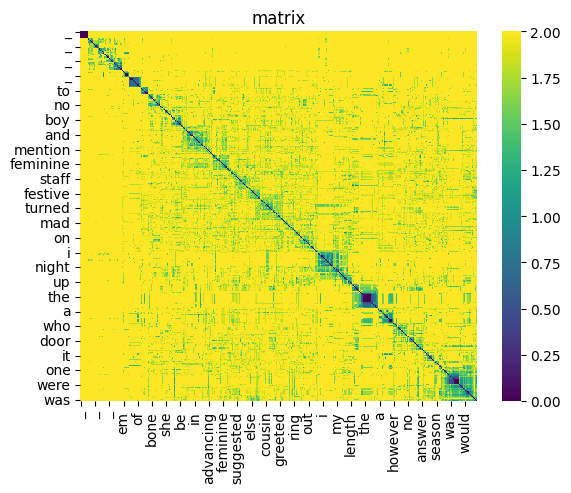

In [107]:
from eval import pairwise_edit_dist_mat

pairwise_edit_dist_mat(dist_mat, "matrix", true_words)

In [ ]:
import editdistance
import itertools
import statistics


def ned(word_clusters, print_pure=False, print_inpure=True):
    distances = []
    for i, clust in tqdm(
        enumerate(word_clusters), total=len(word_clusters), desc="Calculating NED"
    ):
        if len(clust) > 1:
            clust_dist = []

            for p, q in itertools.combinations(clust, 2):
                dist = editdistance.eval(p, q)
                clust_dist.append(dist)
                distances.append(dist)

            if any(dist > 0 for dist in clust_dist) and print_inpure or print_pure:
                print(f"Cluster {i}: {statistics.mean(clust_dist)}")
                words = [j for j in clust]
                print(", ".join(words))
                print()

    return statistics.mean(distances) if distances else 0


In [110]:
ned(word_clusters)

Calculating NED: 100%|██████████| 343/343 [00:00<00:00, 495060.66it/s]

Cluster 7: 1
no, no, no, know

Cluster 26: 0.6666666666666666
it, if, it

Cluster 41: 0.8
there, there's, there, there, there

Cluster 42: 0.5
and, and, and, an

Cluster 51: 3
he, you

Cluster 54: 0.6083333333333333
i, i, i, i, i, i, i, are, i, i, i, i, i, i'm, i, i

Cluster 71: 3
would, were, when, were

Cluster 92: 0.6666666666666666
an, in, an

Cluster 117: 1.3333333333333333
with, what, which, which, which, which, which

Cluster 141: 1
long, along

Cluster 147: 1
kind, kinds

Cluster 250: 2
did, it

Cluster 312: 4
with, would



0.2178932178932179